In [3]:
import os
import warnings
import tifffile
import datetime
import sys
sys.path.append("..")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter1d

import obf_support

# warning suppression
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

c:\Users\alvelidjonatan\miniconda3\envs\mfxdata\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
eventfolders_all = []
topfolders = [os.path.join(parentdir, 'exampledata\\dyn1\\241101'), os.path.join(parentdir, 'exampledata\\dyn1\\241121')]
for topfolder in topfolders:
    samplefolders = os.listdir(topfolder)
    for samplefolder in samplefolders:
        if os.path.isdir(os.path.join(topfolder,samplefolder)):
            cellfolders = os.listdir(os.path.join(topfolder,samplefolder))
            for cellfolder in cellfolders:
                eventfolders = os.listdir(os.path.join(topfolder,samplefolder,cellfolder))
                for eventfolder in eventfolders:
                    if 'nomfx' not in eventfolder:
                        eventfolders_all.append(os.path.join(topfolder,samplefolder,cellfolder, eventfolder))

print(eventfolders_all)

['c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\dyn1\\241101\\sample1\\cell2\\e1', 'c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\dyn1\\241101\\sample1\\cell2\\e2', 'c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\dyn1\\241121\\sample2\\cell3\\e1', 'c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\dyn1\\241121\\sample2\\cell3\\e2']


In [ ]:
%matplotlib agg
%matplotlib agg

eventfolders = eventfolders_all
for folder in eventfolders:
    print(folder)
    filelist = os.listdir(folder)
    filelist_npy = [file for file in filelist if file.endswith('.npy')]
    filelist_confs = [file for file in filelist if 'conf' in file and 'analysis' not in file and 'stack' not in file]
    filelist_msr = [file for file in filelist if file.endswith('.msr')]
    filelist_logs = [file for file in filelist if file.endswith('.txt')]

    # load msr file to read confocal image settings
    # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
    file_msr = os.path.join(folder, filelist_msr[0])
    msr_dataset = obf_support.File(file_msr)
    conf_msr_stack_index = 0  # in currently used imspector template file, the confocal dataset is always stack 0 in the .msr file. This might change with other templates used.
    conf_stack = msr_dataset.stacks[conf_msr_stack_index]
    conf_img_last = [np.reshape(conf_stack.data, (conf_stack.shape[0], conf_stack.shape[1])).T]  # read last confocal image from msr file
    pxsize = conf_stack.pixel_sizes[0]*1e6
    pxshift = pxsize/2
    conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
    conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
    conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)
    # get roi pos
    roi_pos = (int(filelist_npy[0].split('[')[1].split(',')[0]),int(filelist_npy[0].split(']')[0].split(',')[1]))
    roi_pos_um = (roi_pos[0]*pxsize+conf_offset[0], roi_pos[1]*pxsize+conf_offset[1])

    # set other parameters for the plotting
    N_rois = len(filelist_msr)
    roi_idx_cum = 0
    nl = '\n'
    plt_roi_size = int(np.ceil(0.8/pxsize))
    sum_size = int(np.ceil(0.24/pxsize))
    mfx_size = 0.8
    large_sum_size = int(np.ceil(mfx_size*1.2/2/pxsize))
    t_finframe = 3  # time in s for final confocal frame preevent and the time between that frame and mfx initialization (should always be 2-5 s, depending on confocal frame size)
    t_mfxtoconf = 9  # time in s between a mfx cycle end and a confocal frame start (+7s due to DM error)

    # get all confocal images in one stack
    images_conf = []
    for conf_file in filelist_confs:
        images_conf.append(tifffile.imread(os.path.join(folder, conf_file)))
    frames_preevent = len(images_conf[0])
    images_conf = np.concatenate(images_conf)
    images_conf = np.concatenate([images_conf, conf_img_last])
    #tifffile.imwrite(file_msr.split('_')[0]+'_confstack.tif', images_conf)

    # read timing info from log file
    file_log = os.path.join(folder, filelist_logs[0])
    log_dict = {}
    with open(file_log) as f:
        for line in f:
            key, sep, value = line.strip().partition(": ")
            log_dict[key] = value
    t_mfxcycs = []
    try:
        t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate-cycle0'], '%Hh%Mm%Ss%fus')
        t_mfxcyc0 = datetime.datetime.strptime(log_dict['mfx_end-cycle0'], '%Hh%Mm%Ss%fus')
        try:
            t_mfxcyc1 = datetime.datetime.strptime(log_dict['mfx_end-cycle1'], '%Hh%Mm%Ss%fus')
        except:
            t_mfxcyc1 = datetime.datetime.strptime(log_dict['mfx_end'], '%Hh%Mm%Ss%fus')
        t_sec_mfx = (t_mfxcyc1-t_mfxcyc0).seconds  # time between confocal frames during MFX
    except:
        try:
            t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate-cycle0'], '%Hh%Mm%Ss%fus')
        except:
            t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate'], '%Hh%Mm%Ss%fus')
        t_mfxcyc0 = datetime.datetime.strptime(log_dict['mfx_end'], '%Hh%Mm%Ss%fus')
        t_sec_mfx = (t_mfxcyc0-t_confevent_end).seconds  # time between confocal frames during MFX
    try:
        t_conf0_start = datetime.datetime.strptime(log_dict['experiment_start'], '%Hh%Mm%Ss%fus')
    except:
        t_conf0_start = datetime.datetime.strptime('12h00m00s000000us', '%Hh%Mm%Ss%fus')
    t_sec_frames_preevent = (t_confevent_end-t_conf0_start).seconds  # time between confocal frames before MFX
    t_sec_mfx0 = (t_mfxcyc0-t_confevent_end).seconds  # time for one MFX rec

    # get t array for all confocal frames
    t = np.linspace(0, t_sec_frames_preevent-t_finframe, frames_preevent)
    t_eventdetect = t[-1]
    t = np.append(t, t[-1]+t_sec_mfx0+t_mfxtoconf)
    for _ in range(len(filelist_confs)-2+1):
        t = np.append(t,t[-1]+t_sec_mfx+t_mfxtoconf)

    # create figure for plotting
    cols = 4
    rows = 1+(len(images_conf)//cols+1)  # 1 for plots, the rest for the number of confocal frames
    fig, ax = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    # get intensity limits for confocal images
    conf_zoom_lim = (np.min(images_conf[:,roi_pos[1]-sum_size:roi_pos[1]+sum_size, roi_pos[0]-sum_size:roi_pos[0]+sum_size]), np.max(images_conf[:,roi_pos[1]-sum_size:roi_pos[1]+sum_size, roi_pos[0]-sum_size:roi_pos[0]+sum_size]))
    # get x,y lims for confocal image zooms
    lims_confimg = np.array([roi_pos_um[0], roi_pos_um[0], roi_pos_um[1], roi_pos_um[1]]) + np.array([-plt_roi_size, plt_roi_size, -plt_roi_size, plt_roi_size])*pxsize
    # plot image zooms and plots of intensity over time
    spot_sums = []
    large_sums = []
    for conf_idx_p in range(len(images_conf)):
        conf_idx = len(images_conf)-conf_idx_p-1
        plotrow = conf_idx//cols+1
        plotcol = conf_idx%cols
        conf_img = images_conf[conf_idx_p]
        spot_sums.append(np.sum(np.sum(conf_img[roi_pos[1]-sum_size:roi_pos[1]+sum_size+1, roi_pos[0]-sum_size:roi_pos[0]+sum_size+1]))/sum_size**2)
        large_sums.append(np.sum(np.sum(conf_img[roi_pos[1]-large_sum_size:roi_pos[1]+large_sum_size+1, roi_pos[0]-large_sum_size:roi_pos[0]+large_sum_size+1]))/large_sum_size**2)
        rolling_window = 9
        spot_sums_sm = uniform_filter1d(spot_sums, size=rolling_window, mode='nearest')
        large_sums_sm = uniform_filter1d(large_sums, size=rolling_window, mode='nearest')
        img_onlyconf = ax[plotrow,plotcol].imshow(conf_img, cmap='hot', vmin=conf_zoom_lim[0], vmax=conf_zoom_lim[1])
        if conf_idx_p == 0:
            extents_confimg = np.array(img_onlyconf.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
        img_onlyconf.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks
        ax[plotrow,plotcol].set_xlim(lims_confimg[:2])
        ax[plotrow,plotcol].set_ylim(lims_confimg[2:])
        if conf_idx_p == frames_preevent-1:
            ax[plotrow,plotcol].patch.set_linewidth(10)
            ax[plotrow,plotcol].patch.set_edgecolor('green')
        ax[plotrow,plotcol].scatter(roi_pos[0]*pxsize+pxsize/2+conf_offset[0], roi_pos[1]*pxsize+pxsize/2+conf_offset[1], marker='x', color='green', s=40)
        ax[plotrow,plotcol].invert_yaxis()
        legend_text = f'Frame {conf_idx_p}'
        if conf_idx == 0:
            legend_text = legend_text + f', post MFX {len(filelist_npy)-conf_idx-1}'
        elif conf_idx < len(filelist_npy)+1:
            legend_text = legend_text + f', pre MFX {len(filelist_npy)-conf_idx}'
        ax[plotrow,plotcol].legend([legend_text], loc='upper right', labelcolor='w', facecolor=None, frameon=False, markerscale=0, prop={'size': 12})
    if len(t) > len(spot_sums):
        t = t[:-1]
    ax[0,0].plot(t, spot_sums, '-', color='k')
    ax[0,0].plot(t, spot_sums_sm, '--', color='gray')
    ax[0,0].axvline(x=t_eventdetect, linewidth=8, color='g', alpha=0.6)
    ax[0,0].set_xlabel('time (s) (up to event)')
    ax[0,0].set_ylabel('intensity, event area (a.u.)')
    ax[0,0].set_xlim([0, t_eventdetect+t_eventdetect/7])
    ax[0,0].set_ylim([0, np.max(spot_sums)])
    ax[0,1].plot(t, spot_sums, '-', color='k')
    ax[0,1].plot(t, spot_sums_sm, '--', color='gray')
    ax[0,1].axvline(x=t_eventdetect, linewidth=8, color='g', alpha=0.6)
    ax[0,1].set_xlabel('time (s) (full)')
    ax[0,1].set_ylabel('intensity, event area (a.u.)')
    ax[0,1].set_ylim([0, np.max(spot_sums)])
    ax[0,2].plot(t, large_sums, '-', color='k')
    ax[0,2].plot(t, large_sums_sm, '--', color='gray')
    ax[0,2].axvline(x=t_eventdetect, linewidth=8, color='g', alpha=0.6)
    ax[0,2].set_xlabel('time (s) (full)')
    ax[0,2].set_ylabel('intensity, larger area (a.u.)')
    ax[0,2].set_ylim([0, np.max(large_sums)])

    ### save fig
    pdf = mpl.backends.backend_pdf.PdfPages(os.path.join(folder,"summary-event.pdf"))
    for i in plt.get_fignums():
        pdf.savefig(i)
    pdf.close()
    plt.close('all')

C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell1\e11
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell1\e2
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell1\e3
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell1\e6
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell1\e9
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell2\e1
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell2\e4
C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\no-ves\241122\sample3\cell2\e5


C:\Users\alvelidjonatan\Documents\Data\etMINFLUX-lab\data-dyn1\memb-3d\ves\241101\sample1\cell2\e3
['241101-104133_conf-raw.tif', '241101-104205_conf-raw.tif', '241101-104237_conf-raw.tif', '241101-104309_conf-raw.tif', '241101-104340_conf-raw.tif', '241101-104412_conf-raw.tif', '241101-104444_conf-raw.tif', '241101-104516_conf-raw.tif', '241101-104547_conf-raw.tif', '241101-104619_conf-raw.tif', '241101-104651_conf-raw.tif', '241101-104723_conf-raw.tif', '241101-104758_conf-raw.tif']


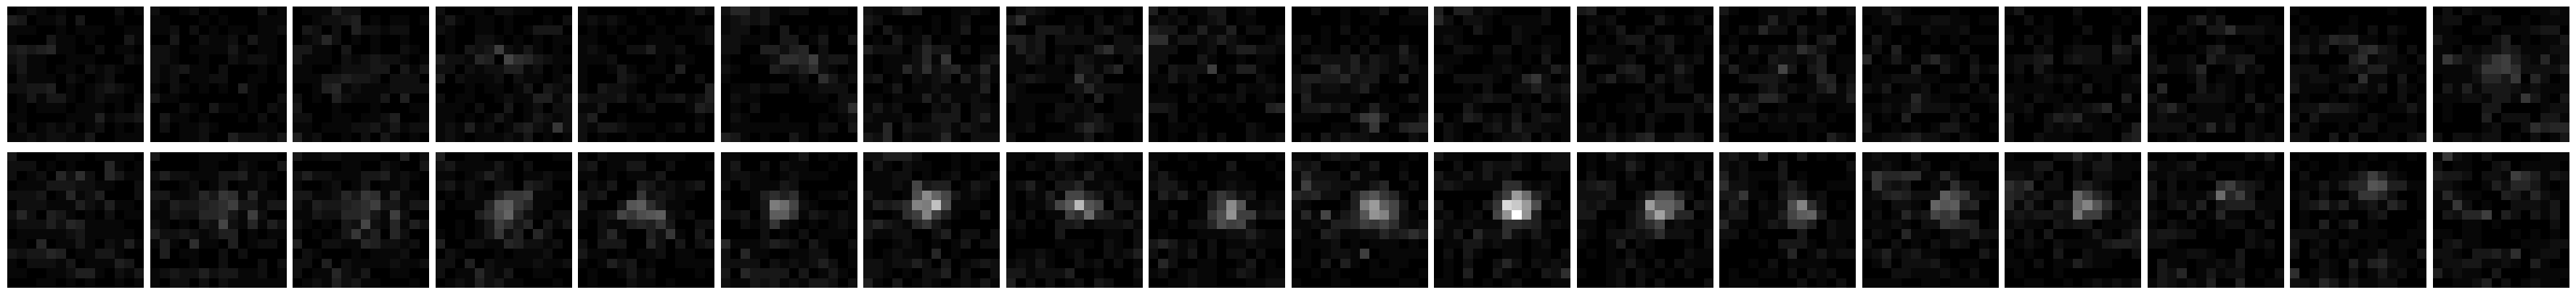

In [ ]:
## EVENT FRAMES SUBFIGURE FOR SUPPLEMENTARY

%matplotlib inline

eventfolders = eventfolders_all
for folder in eventfolders:
    print(folder)
    filelist = os.listdir(folder)
    filelist_npy = [file for file in filelist if file.endswith('.npy')]
    filelist_confs = [file for file in filelist if 'conf' in file and 'analysis' not in file and 'stack' not in file and 'frame' not in file]
    print(filelist_confs)
    filelist_msr = [file for file in filelist if file.endswith('.msr')]
    filelist_logs = [file for file in filelist if file.endswith('.txt')]

    # load msr file to read confocal image settings
    # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
    file_msr = os.path.join(folder, filelist_msr[0])
    msr_dataset = obf_support.File(file_msr)
    conf_msr_stack_index = 0  # in currently used imspector template file, the confocal dataset is always stack 0 in the .msr file. This might change with other templates used.
    conf_stack = msr_dataset.stacks[conf_msr_stack_index]
    conf_img_last = [np.reshape(conf_stack.data, (conf_stack.shape[0], conf_stack.shape[1])).T]  # read last confocal image from msr file
    pxsize = conf_stack.pixel_sizes[0]*1e6
    pxshift = pxsize/2
    conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
    conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
    conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)
    # get roi pos
    roi_pos = (int(filelist_npy[0].split('[')[1].split(',')[0]),int(filelist_npy[0].split(']')[0].split(',')[1]))
    roi_pos_um = (roi_pos[0]*pxsize+conf_offset[0], roi_pos[1]*pxsize+conf_offset[1])

    # set other parameters for the plotting
    N_rois = len(filelist_msr)
    roi_idx_cum = 0
    nl = '\n'
    plt_roi_size_rad = int(np.ceil(0.9/2/pxsize))

    # get all confocal images in one stack
    images_conf = []
    for conf_file in filelist_confs:
        images_conf.append(tifffile.imread(os.path.join(folder, conf_file)))
    frames_preevent = len(images_conf[0])
    images_conf = np.concatenate(images_conf)
    images_conf = np.concatenate([images_conf, conf_img_last])

    # create figure for plotting
    cols = 18
    rows = 2
    fig, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    # get intensity limits for confocal images
    conf_zoom_lim = (np.min(images_conf[:,roi_pos[1]-plt_roi_size_rad:roi_pos[1]+plt_roi_size_rad, roi_pos[0]-plt_roi_size_rad:roi_pos[0]+plt_roi_size_rad]), np.max(images_conf[:,roi_pos[1]-plt_roi_size_rad:roi_pos[1]+plt_roi_size_rad, roi_pos[0]-plt_roi_size_rad:roi_pos[0]+plt_roi_size_rad]))
    # get x,y lims for confocal image zooms
    lims_confimg = np.array([roi_pos_um[0], roi_pos_um[0], roi_pos_um[1], roi_pos_um[1]]) + np.array([-plt_roi_size_rad, plt_roi_size_rad, -plt_roi_size_rad, plt_roi_size_rad])*pxsize
    # plot image zooms and plots of intensity over time
    spot_sums = []
    large_sums = []
    startidx = 27
    for conf_idx in range(startidx+36):
        try:
            plotidx = conf_idx-startidx
            plotrow = plotidx//cols
            plotcol = plotidx%cols
            conf_img = images_conf[conf_idx]
            img_onlyconf = ax[plotrow,plotcol].imshow(conf_img, cmap='gist_gray', vmin=conf_zoom_lim[0], vmax=conf_zoom_lim[1])
            if plotidx == 0:
                extents_confimg = np.array(img_onlyconf.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
            img_onlyconf.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks
            ax[plotrow,plotcol].set_xlim(lims_confimg[:2])
            ax[plotrow,plotcol].set_ylim(lims_confimg[2:])
        except:
            pass
        ax[plotrow,plotcol].set_axis_off()

    plt.subplots_adjust(left=0.01, right=0.99, 
                        top=0.99, bottom=0.01, 
                        wspace=0.05, hspace=0.05)
    
    plt.show()